## Cluster Cluster
See if we can cluster clusters of modifications so we can may be able to see paterns of modification profiles within regions we cannot resolve well

In [2]:
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists, list_dir
from py3helpers.seq_tools import ReferenceHandler
import umap

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [3]:
from signalalign.fast5 import Fast5

In [4]:
reference_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa"
rh = ReferenceHandler(reference_path)

In [116]:
ivt_25_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/tombo_embedded/IVT/ivt_25S_full_length"
nopglu_25_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/tombo_embedded/NOP58_GLU/Nop58_GLU_25S_full_length"
cbf5glu_25_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/tombo_embedded/CBF5_GLU/CBF5_GLU_25S_full_length"
cbf5gal_25_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/tombo_embedded/CBF5_GAL/CBF5_GAL_25S_full_length"
nopgal_25_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/tombo_embedded/NOP58_GAL/NOP58_GAL_25S_full_length"


In [17]:
def decode(x):
    return x.decode("utf-8")

def get_read_events(read, start, length):
    test = Fast5(read)
    events, corr_start_rel_to_raw = test.get_corrected_events()
    events = pd.DataFrame(events)
    events["nuc"] = events["base"].apply(decode)
    attr = test.get_corrected_events_attr()
    offset = attr["mapped_start"]
    subset = events.iloc[start-offset:start-offset+length]
#     print(subset["nuc"])
    return subset["norm_mean"].values


In [121]:
def get_experiment_events(directory, label, start, length, n=100, verbose=False):
    data = []
    file_paths = list_dir(directory, ext="fast5")
    i = 0
    for read in file_paths:
        try:
            i += 1
            data.append(get_read_events(read, start, length))
            if i >= n:
                break
        except Exception as e:
            if verbose:
                print(f"{read}, {e}")

    data = pd.DataFrame(data)
    data["label"] = label
    return data

In [230]:
x = pd.Series([1]*10)

def get_norm(y, x=None):
    return np.linalg.norm(x-y)


In [236]:
path_name_mapping = [[ivt_25_path, "ivt_25"], 
                     [nopglu_25_path, "nopglu_25"], 
                     [cbf5glu_25_path, "cbf5glu_25"],
                     [nopgal_25_path, "nopgal_25"], 
                     [cbf5gal_25_path, "cbf5gal_25"]]

n_reads = 500
pos = 2415
length = 10

start = pos - (length // 2)
data_frames = []
label_map = {}
labels_list = []
for i, (path, name) in enumerate(path_name_mapping):
    data_frames.append(get_experiment_events(path, name, start, length, n=n_reads))
    label_map[name] = i
    labels_list.append(name)

final_df = pd.concat(data_frames, ignore_index=True)
print(final_df.isna().sum())
final_df = final_df.dropna()
labels_true = final_df["label"].map(label_map)
X = final_df.loc[:, final_df.columns != 'label']


35.551139068114615 ivt_25
40.997037826331805 nopglu_25
39.224520503823776 cbf5glu_25
34.769397618346304 nopgal_25
35.97395988308054 cbf5gal_25
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
label    0
dtype: int64


In [211]:
# import umap.umap_ as umap
# import umap.umap_ as umap
reducer = umap.UMAP()
umap_results = reducer.fit_transform(X)


<IPython.core.display.Javascript object>


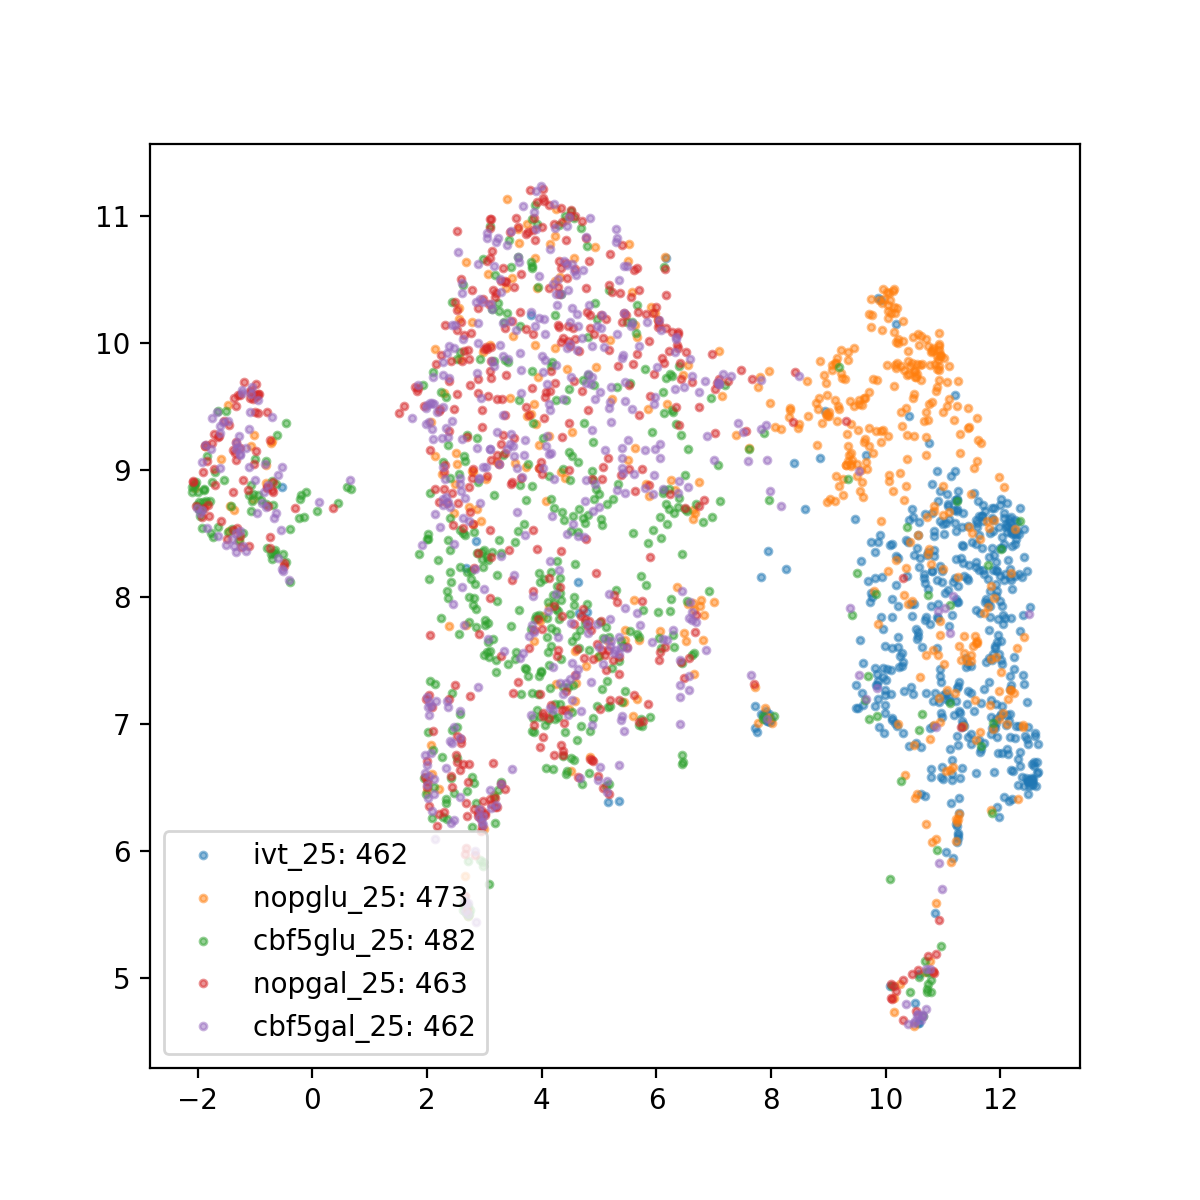

In [213]:
%matplotlib notebook
plt.figure(figsize=(6,6))
unique_labels = set(labels_true)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

# Black removed and is used for noise instead.
# plt.plot(umap_results[:, 0], umap_results[:, 1], 'o')
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels_true == k)
    xy = umap_results[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markersize=5, alpha=0.5, label=f"{labels_list[k]}: {len(xy)}")     
plt.legend()


In [215]:
final_df

,0,1,2,3,4,5,6,7,8,9,label
0,1.551075,2.269364,2.048394,1.962594,-1.163801,-0.051976,1.483661,2.116612,-0.438155,-0.703939,ivt_25
1,1.295533,2.317333,1.578443,1.971899,-0.562409,1.590020,1.554694,2.768266,-0.194285,-0.504639,ivt_25
2,1.173786,2.041691,1.732833,1.558147,-1.110936,0.002773,1.782933,2.307051,-0.464389,-1.048088,ivt_25
3,1.660472,2.000071,1.976118,1.964115,-1.190914,-0.076663,1.633154,1.921212,-0.337466,-0.934460,ivt_25
4,1.291539,1.915897,2.156912,2.496233,-1.068482,0.028445,1.553509,2.676312,-0.323462,-0.844060,ivt_25
...,...,...,...,...,...,...,...,...,...,...,...
2421,1.211932,1.484632,2.175123,2.186440,-1.320916,-0.550770,0.749632,1.364216,0.022805,-1.690213,cbf5gal_25
2422,1.526023,1.422800,1.659060,1.508788,-1.816248,-0.161825,1.357035,1.013267,-0.309670,-0.639649,cbf5gal_25
2423,1.553114,2.382837,1.935477,0.859065,-1.825150,-0.334484,1.223389,1.446128,-0.125735,-1.101766,cbf5gal_25
2424,1.659719,2.390032,1.853670,1.751414,-1.837974,-0.072249,0.961091,0.189461,-0.003075,-1.357953,cbf5gal_25


In [229]:
x = pd.Series([1]*10)

def get_norm(y, x=None):
    return np.linalg.norm(x-y)

# x = pd.Series([1, 2, 3, 4, 5])
# y = pd.Series([6, 7, 8, 9, 10])
# dist = (np.linalg.norm(x-y))
deltas = X.apply(get_norm, x=x, axis=1)
[labels_true == 0]


0      4.022664
1      3.607747
2      4.009348
3      4.007301
4      4.241705
         ...   
483    3.451296
484    3.949424
485    4.049323
486    4.046661
487    3.846346
Length: 462, dtype: float64

In [228]:
labels_true == 0

0        True
1        True
2        True
3        True
4        True
        ...  
2421    False
2422    False
2423    False
2424    False
2425    False
Name: label, Length: 2342, dtype: bool